# Multitask QEP Regression

## Introduction

Multitask regression, introduced in [this paper](https://papers.nips.cc/paper/3189-multi-task-gaussian-process-prediction.pdf) learns similarities in the outputs simultaneously. It's useful when you are performing regression on multiple functions that share the same inputs, especially if they have similarities (such as being sinusodial). 

Given inputs $x$ and $x'$, and tasks $i$ and $j$, the covariance between two datapoints and two tasks is given by

$$  k([x, i], [x', j]) = k_\text{inputs}(x, x') * k_\text{tasks}(i, j)
$$

where $k_\text{inputs}$ is a standard kernel (e.g. RBF) that operates on the inputs.
$k_\text{task}$ is a lookup table containing inter-task covariance.

In [1]:
import math
import torch
import qpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

### Set up training data

In the next cell, we set up the training data for this example. We'll be using 100 regularly spaced points on [0,1] which we evaluate the function on and add Gaussian noise to get the training labels.

We'll have two functions - a sine function (y1) and a cosine function (y2).

For MTQEPs, our `train_targets` will actually have two dimensions: with the second dimension corresponding to the different tasks.

In [2]:
train_x = torch.linspace(0, 1, 100)

train_y = torch.stack([
    torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2,
    torch.cos(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2,
], -1)

## Define a multitask model

The model should be somewhat similar to the `ExactQEP` model in the [simple regression example](../01_Exact_QEPs/Simple_QEP_Regression.ipynb).
The differences:

1. We're going to wrap ConstantMean with a `MultitaskMean`. This makes sure we have a mean function for each task.
2. Rather than just using a RBFKernel, we're using that in conjunction with a `MultitaskKernel`. This gives us the covariance function described in the introduction.
3. We're using a `MultitaskMultivariateNormal` and `MultitaskGaussianLikelihood`. This allows us to deal with the predictions/outputs in a nice way. For example, when we call MultitaskMultivariateNormal.mean, we get a `n x num_tasks` matrix back.

You may also notice that we don't use a ScaleKernel, since the MultitaskKernel will do some scaling for us. (This way we're not overparameterizing the kernel.)

In [3]:
POWER = 1.0
class MultitaskQEPModel(qpytorch.models.ExactQEP):
    def __init__(self, train_x, train_y, likelihood):
        super(MultitaskQEPModel, self).__init__(train_x, train_y, likelihood)
        self.power = torch.tensor(POWER)
        self.mean_module = qpytorch.means.MultitaskMean(
            qpytorch.means.ConstantMean(), num_tasks=2
        )
        self.covar_module = qpytorch.kernels.MultitaskKernel(
            qpytorch.kernels.RBFKernel(), num_tasks=2, rank=1
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return qpytorch.distributions.MultitaskMultivariateQExponential(mean_x, covar_x, power=self.power)

    
likelihood = qpytorch.likelihoods.MultitaskQExponentialLikelihood(num_tasks=2, power=torch.tensor(POWER))
model = MultitaskQEPModel(train_x, train_y, likelihood)

### Train the model hyperparameters

In [4]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iterations = 2 if smoke_test else 60


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for QEPs - the marginal log likelihood
mll = qpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
    optimizer.step()

Iter 1/60 - Loss: 2.035
Iter 2/60 - Loss: 1.984
Iter 3/60 - Loss: 1.932
Iter 4/60 - Loss: 1.877
Iter 5/60 - Loss: 1.820
Iter 6/60 - Loss: 1.760
Iter 7/60 - Loss: 1.699
Iter 8/60 - Loss: 1.639
Iter 9/60 - Loss: 1.584
Iter 10/60 - Loss: 1.538
Iter 11/60 - Loss: 1.502
Iter 12/60 - Loss: 1.474
Iter 13/60 - Loss: 1.450
Iter 14/60 - Loss: 1.429
Iter 15/60 - Loss: 1.409
Iter 16/60 - Loss: 1.390
Iter 17/60 - Loss: 1.372
Iter 18/60 - Loss: 1.354
Iter 19/60 - Loss: 1.336
Iter 20/60 - Loss: 1.318
Iter 21/60 - Loss: 1.300
Iter 22/60 - Loss: 1.281
Iter 23/60 - Loss: 1.262
Iter 24/60 - Loss: 1.242
Iter 25/60 - Loss: 1.222
Iter 26/60 - Loss: 1.202
Iter 27/60 - Loss: 1.181
Iter 28/60 - Loss: 1.159
Iter 29/60 - Loss: 1.138
Iter 30/60 - Loss: 1.116
Iter 31/60 - Loss: 1.093
Iter 32/60 - Loss: 1.070
Iter 33/60 - Loss: 1.047
Iter 34/60 - Loss: 1.024
Iter 35/60 - Loss: 1.000
Iter 36/60 - Loss: 0.977
Iter 37/60 - Loss: 0.953
Iter 38/60 - Loss: 0.930
Iter 39/60 - Loss: 0.906
Iter 40/60 - Loss: 0.883
Iter 41/6

### Make predictions with the model

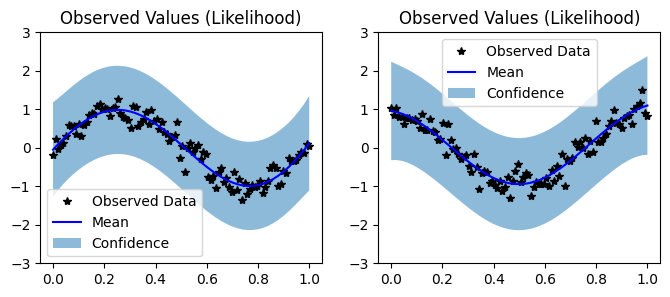

In [5]:
# Set into eval mode
model.eval()
likelihood.eval()

# Initialize plots
f, (y1_ax, y2_ax) = plt.subplots(1, 2, figsize=(8, 3))

# Make predictions
with torch.no_grad(), qpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 51)
    predictions = likelihood(model(test_x))
    mean = predictions.mean
    lower, upper = predictions.confidence_region(rescale=True)
    
# This contains predictions for both tasks, flattened out
# The first half of the predictions is for the first task
# The second half is for the second task

# Plot training data as black stars
y1_ax.plot(train_x.detach().numpy(), train_y[:, 0].detach().numpy(), 'k*')
# Predictive mean as blue line
y1_ax.plot(test_x.numpy(), mean[:, 0].numpy(), 'b')
# Shade in confidence 
y1_ax.fill_between(test_x.numpy(), lower[:, 0].numpy(), upper[:, 0].numpy(), alpha=0.5)
y1_ax.set_ylim([-3, 3])
y1_ax.legend(['Observed Data', 'Mean', 'Confidence'])
y1_ax.set_title('Observed Values (Likelihood)')

# Plot training data as black stars
y2_ax.plot(train_x.detach().numpy(), train_y[:, 1].detach().numpy(), 'k*')
# Predictive mean as blue line
y2_ax.plot(test_x.numpy(), mean[:, 1].numpy(), 'b')
# Shade in confidence 
y2_ax.fill_between(test_x.numpy(), lower[:, 1].numpy(), upper[:, 1].numpy(), alpha=0.5)
y2_ax.set_ylim([-3, 3])
y2_ax.legend(['Observed Data', 'Mean', 'Confidence'])
y2_ax.set_title('Observed Values (Likelihood)')

None